In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import entropy, wasserstein_distance, spearmanr
from scipy.spatial.distance import jensenshannon

# Specify the path to our custom importer
import sys
sys.path.append('..')
from custom_imputer_v02 import KZImputer

# sets for graphics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
seed_value = 42

In [21]:
def evaluate_metrics(true_values, imputed_values, full_true, full_imputed):

    # general metrics
    mae = mean_absolute_error(true_values, imputed_values)
    rmse = np.sqrt(mean_squared_error(true_values, imputed_values))

    mask = np.abs(true_values) > 1e-2
    if np.any(mask):
        mape = np.mean(np.abs((true_values[mask] - imputed_values[mask]) / true_values[mask])) * 100
    else:
        mape = np.nan

    r2 = r2_score(true_values, imputed_values)
    nrmse = rmse / (true_values.max() - true_values.min())

    # universal metrics:
    # Jensen-Shannon divergence
    js = jensenshannon(
        np.histogram(full_true.dropna(), bins = 20, density = True)[0],
        np.histogram(full_imputed.dropna(), bins = 20, density = True)[0]
    )

    # Wasserstein Distance
    wd = wasserstein_distance(full_true.dropna(), full_imputed.dropna())

    # Spearman correlation diff
    corr_orig = full_true.dropna().corr(full_true.dropna(), method = "spearman")
    corr_imputed = full_true.dropna().corr(full_imputed.dropna(), method = "spearman")
    corr_diff = np.abs(corr_orig - corr_imputed)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "NRMSE": nrmse,
        "JS_Divergence": js,
        "Wasserstein": wd,
        "Correlation_Diff": corr_diff,
    }

In [3]:
# --- 2. TESTING ON SYNTHETIC DATA ---
print("--- Testing on synthetic data ---")

data = np.arange(1, 31, dtype = float)
s_synth = pd.Series(data)

# gaps creating with different types (lenghts)
s_gappy = s_synth.copy()
s_gappy.iloc[0] = np.nan # 1-gap left
s_gappy.iloc[14] = np.nan # 1-gap middle
s_gappy.iloc[29] = np.nan # 1-gap right
s_gappy.iloc[3:5] = np.nan # 2-gap middle
s_gappy.iloc[20:25] = np.nan # 5-gap middle

print("Original row with gaps:\n")
print(s_gappy.values)

# use new imputer
imputer_kz = KZImputer(max_gap_size=5)
s_imputed = imputer_kz.transform(s_gappy)

print("\nSeries after imputation:\n")
print(s_imputed.values)


--- Testing on synthetic data ---
Original row with gaps:

[nan  2.  3. nan nan  6.  7.  8.  9. 10. 11. 12. 13. 14. nan 16. 17. 18.
 19. 20. nan nan nan nan nan 26. 27. 28. 29. nan]

Series after imputation:

[ 3.16666667  2.          3.          4.5         4.5         6.
  7.          8.          9.         10.         11.         12.
 13.         14.         15.         16.         17.         18.
 19.         20.         18.         20.375      22.75       25.125
 27.5        26.         27.         28.         29.         28.        ]


In [76]:

# --- 3. WORKING WITH REAL DATA ---
print("\n--- Analysis on real data ---\n")
df = pd.read_csv('T1.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
df = df.set_index('Date/Time')

# only needed column (name cab be chanched)
research_name_col = 'LV ActivePower (kW)'
power_series = df[research_name_col]

# Let's find a continuous piece of data without gaps for our experiment.
clean_slice = power_series.loc['2018-01-15':'2018-01-25'].dropna()
print(f"A clean slice of data of length was taken {len(clean_slice)} points.")

# create the synthetic gaps
np.random.seed(seed_value)
test_series = clean_slice.copy()

# 10 sinle gaps
for _ in range(10):
    idx = np.random.randint(10, len(test_series) - 10)
    test_series.iloc[idx] = np.nan

# 3 gaps with 3 values
for _ in range(3):
    idx = np.random.randint(10, len(test_series) - 15)
    test_series.iloc[idx : idx + 3] = np.nan

# 2 gaps with 5 values
for _ in range(2):
    idx = np.random.randint(10, len(test_series) - 20)
    test_series.iloc[idx : idx + 5] = np.nan

# Let's save the indices where we created gaps
missing_indices = test_series.isna()
print(f"Total created {missing_indices.sum()} missed values.")



--- Analysis on real data ---

A clean slice of data of length was taken 1584 points.
Total created 28 missed values.


In [22]:
# --- 4. COMPARATIVE ANALYSIS ---

# Compared methods
imputers = {
    "KZImputer": KZImputer(max_gap_size = 5),
    "Mean": SimpleImputer(strategy = 'mean'),
    "Median": SimpleImputer(strategy = 'median'),
    "Forward Fill": 'ffill',
    "Backward Fill": 'bfill',
    "Linear Interpolate": 'linear',
    "Spline Interpolate": 'spline',
    "KNN (k=5)": KNNImputer(n_neighbors = 5),
    "IterativeImputer": IterativeImputer(max_iter = 10, random_state = seed_value)
}

results = []

# For imputers that need a 2D array, we transform the data
test_series_2d = test_series.to_frame()

for name, imputer in imputers.items():
    start_time = time.time()

    if isinstance(imputer, str):
        if name == "Linear Interpolate":
            imputed_series = test_series.interpolate(method="linear")
        elif name == "Spline Interpolate":
            imputed_series = test_series.interpolate(method="spline", order=3)
        elif name == "Forward Fill":
            imputed_series = test_series.ffill()
        elif name == "Backward Fill":
            imputed_series = test_series.bfill()
    elif name == "KZImputer":
        imputed_series = imputer.transform(test_series)
    else:
        imputed_data = imputer.fit_transform(test_series_2d)
        imputed_series = pd.Series(imputed_data.flatten(), index = test_series.index)

    elapsed = time.time() - start_time

    # Метрики по истинно пропущенным
    metrics = evaluate_metrics(
        true_values = clean_slice[missing_indices],
        imputed_values = imputed_series[missing_indices],
        full_true = clean_slice,
        full_imputed = imputed_series
    )
    metrics["Time (s)"] = elapsed
    metrics["Method"] = name
    results.append(metrics)

# Итоговый DataFrame
results_df = pd.DataFrame(results).set_index("Method")
results_df = results_df[[
    "MAE", "RMSE", "MAPE", "R2", "NRMSE",
    "JS_Divergence", "Wasserstein", "Correlation_Diff",
    "Time (s)"
]]
results_df

,MAE,RMSE,MAPE,R2,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Time (s)
Method,,,,,,,,,
KZImputer,271.062718,555.912184,1386.534301,0.825410,0.155227,0.007679,3.979796,0.001399,0.003325
Mean,1333.473256,1462.461667,42580.894124,-0.208301,0.408361,0.043217,23.571497,0.009145,0.003019
Median,1322.798252,1442.489834,41352.630197,-0.175525,0.402785,0.043217,23.382797,0.009025,0.002962
Forward Fill,128.958481,285.543470,39.229948,0.953937,0.079732,0.004206,1.078331,0.000343,0.000218
Backward Fill,298.242169,635.173612,44.495604,0.772075,0.177359,0.011815,4.499620,0.000660,0.000203
Linear Interpolate,199.230287,400.425620,34.387256,0.909416,0.111810,0.008983,2.753558,0.000351,0.000608
Spline Interpolate,189.669688,332.505161,235.755766,0.937540,0.092845,0.417290,2.435501,0.001726,0.246424
KNN (k=5),1333.473256,1462.461667,42580.894124,-0.208301,0.408361,0.043217,23.571497,0.009145,0.004881
IterativeImputer,1333.473256,1462.461667,42580.894124,-0.208301,0.408361,0.043217,23.571497,0.009145,0.003133


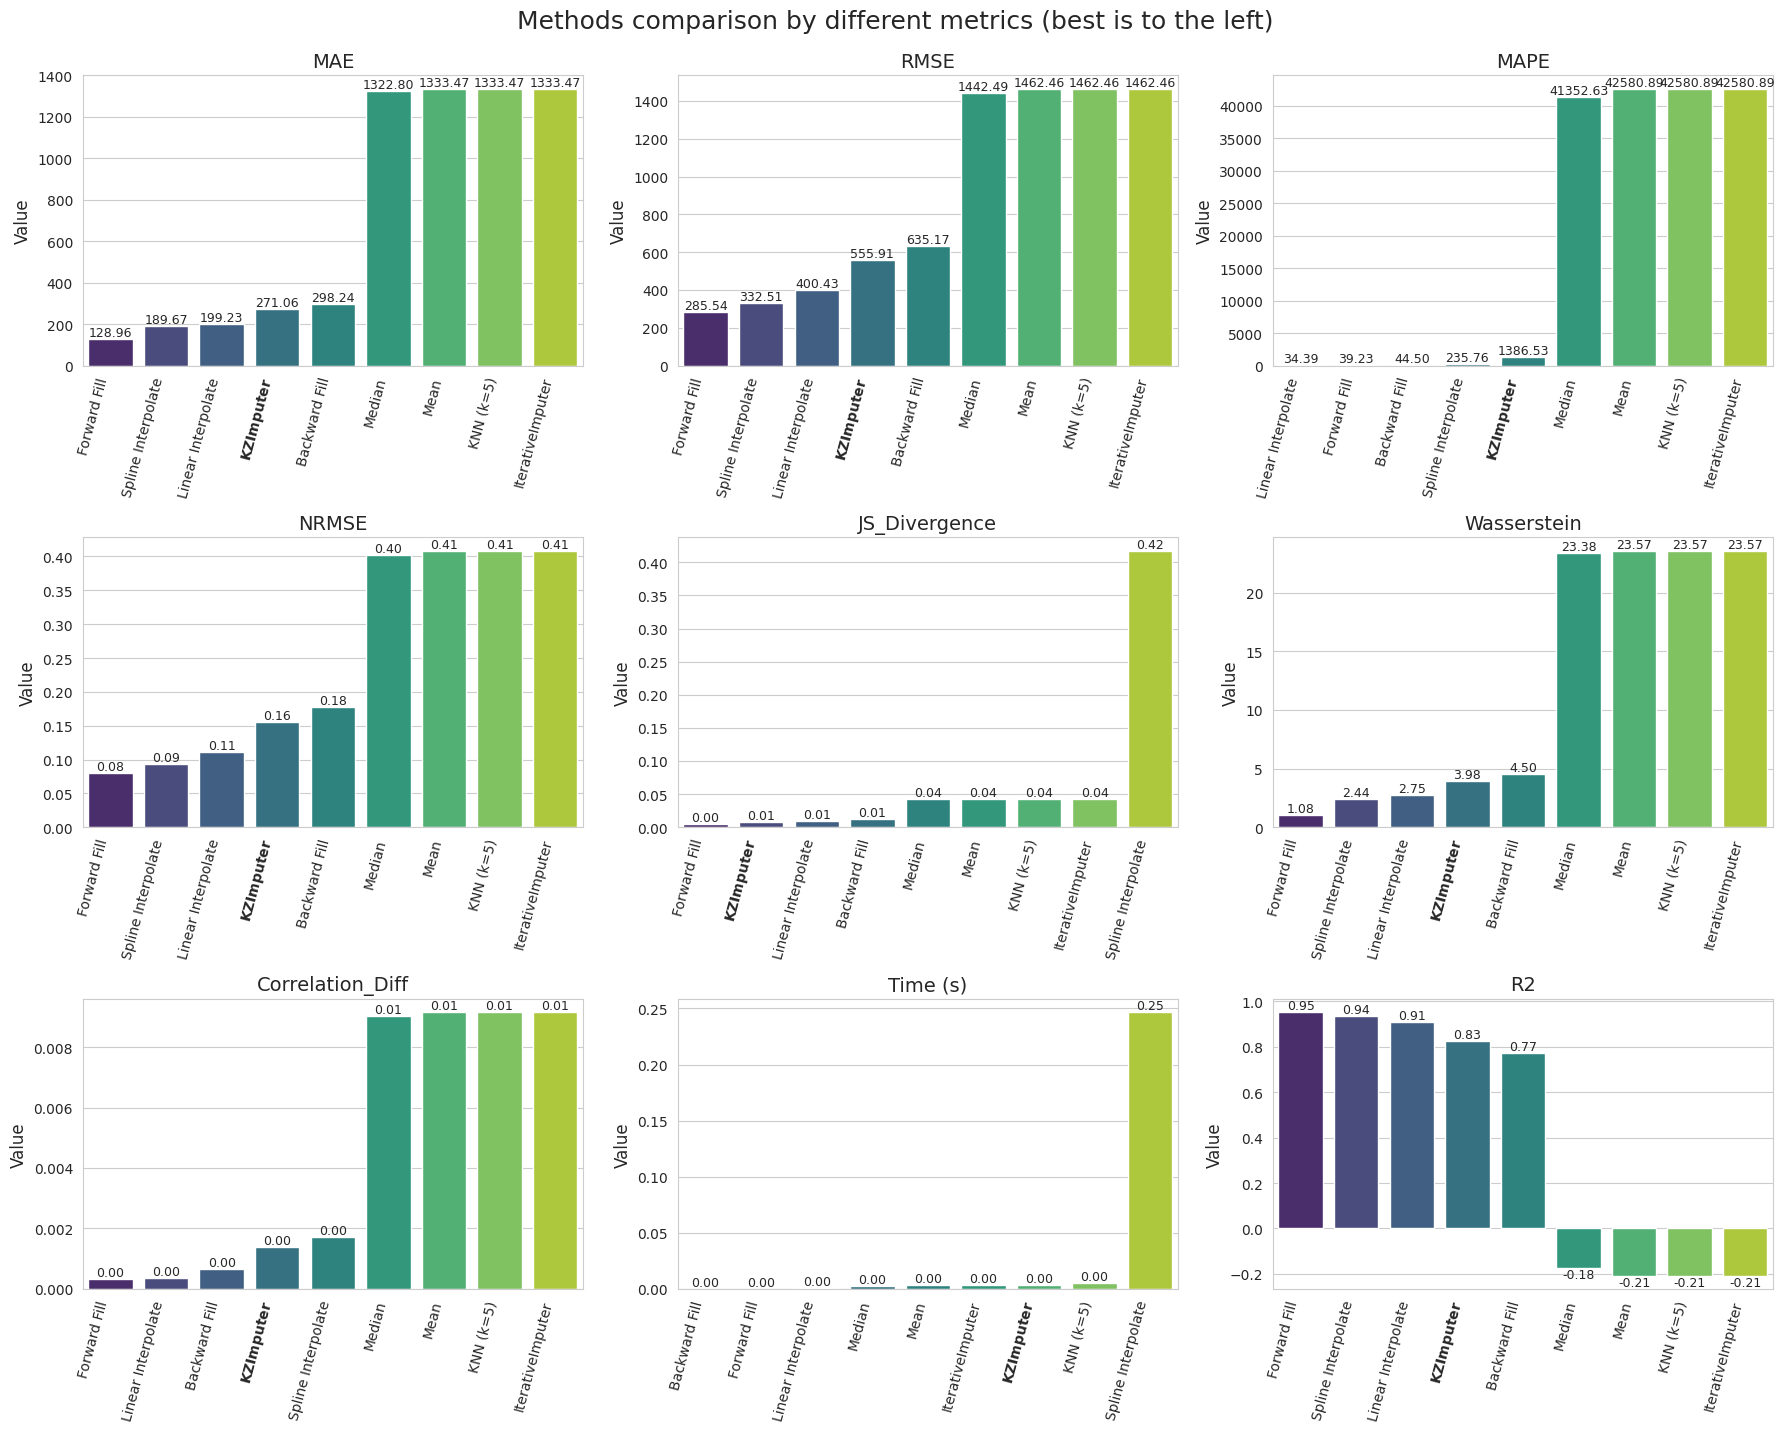

In [74]:
minimize_metrics = ['MAE', 'RMSE', 'MAPE', 'NRMSE', 'JS_Divergence', 'Wasserstein', 'Correlation_Diff', 'Time (s)']
maximize_metrics = ['R2']
all_main_metrics = minimize_metrics[:-1] + maximize_metrics

all_metrics = minimize_metrics + maximize_metrics

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, metric in enumerate(all_metrics):
    ax = axes[i]
    # transform DataFrame with column "Method" and metric
    metric_df = results_df.reset_index()[['Method', metric]].copy()

    # Сортировка
    ascending = metric in minimize_metrics
    metric_df = metric_df.sort_values(by=metric, ascending=ascending)

    # highlight KZImputer (bold font)
    def format_label(method):
        return f"$\\bf{{{method}}}$" if method == "KZImputer" else method

    formatted_labels = [format_label(m) for m in metric_df['Method']]

    sns.barplot(
        data=metric_df,
        x='Method',
        y=metric,
        hue='Method',
        palette='viridis',
        legend=False,
        ax=ax
    )

    ax.set_title(metric, fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xlabel('')
    ax.set_xticks(range(len(formatted_labels)))
    ax.set_xticklabels(formatted_labels, rotation=75, ha='right')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9)

if len(all_metrics) < len(axes):
    for j in range(len(all_metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Methods comparison by different metrics (best is to the left)", fontsize=18, y=1.02)
plt.show()

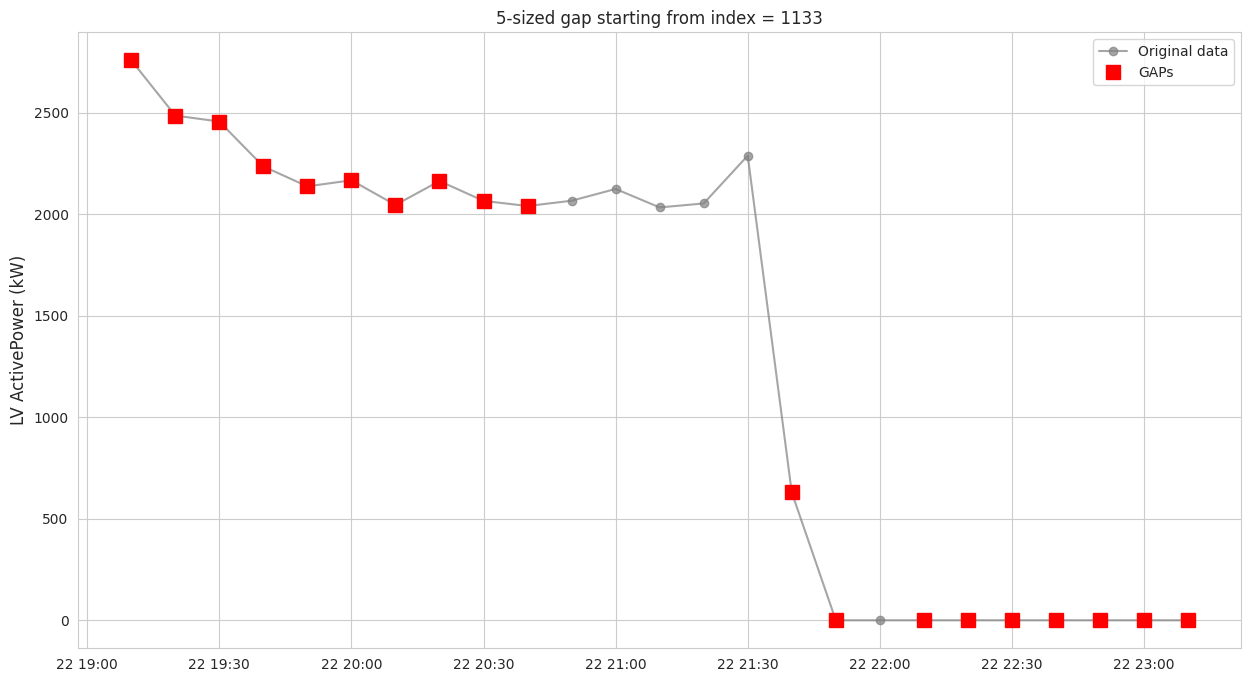

In [77]:
window_size = 5
rolling_na = test_series.isna().rolling(window_size).sum()

# indexes
gaps = rolling_na[rolling_na == window_size]

if gaps.empty:
    raise ValueError(f"❌ Did not find any block with {window_size}-sized consecutive missing values.")

gap_start = gaps.index[0]
gap_start_index = test_series.index.get_loc(gap_start) - (window_size - 1)

# slice arround gap
plot_slice = slice(max(0, gap_start_index - 10), min(len(test_series), gap_start_index + 15))

plt.figure(figsize=(15, 8))
plt.plot(clean_slice.iloc[plot_slice], 'o-', label='Original data', color='gray', alpha=0.7)
plt.plot(test_series.iloc[plot_slice], 's', markersize=10, label='GAPs', color='red')
plt.title(f'{window_size}-sized gap starting from index = {gap_start_index}')
plt.ylabel(research_name_col, fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

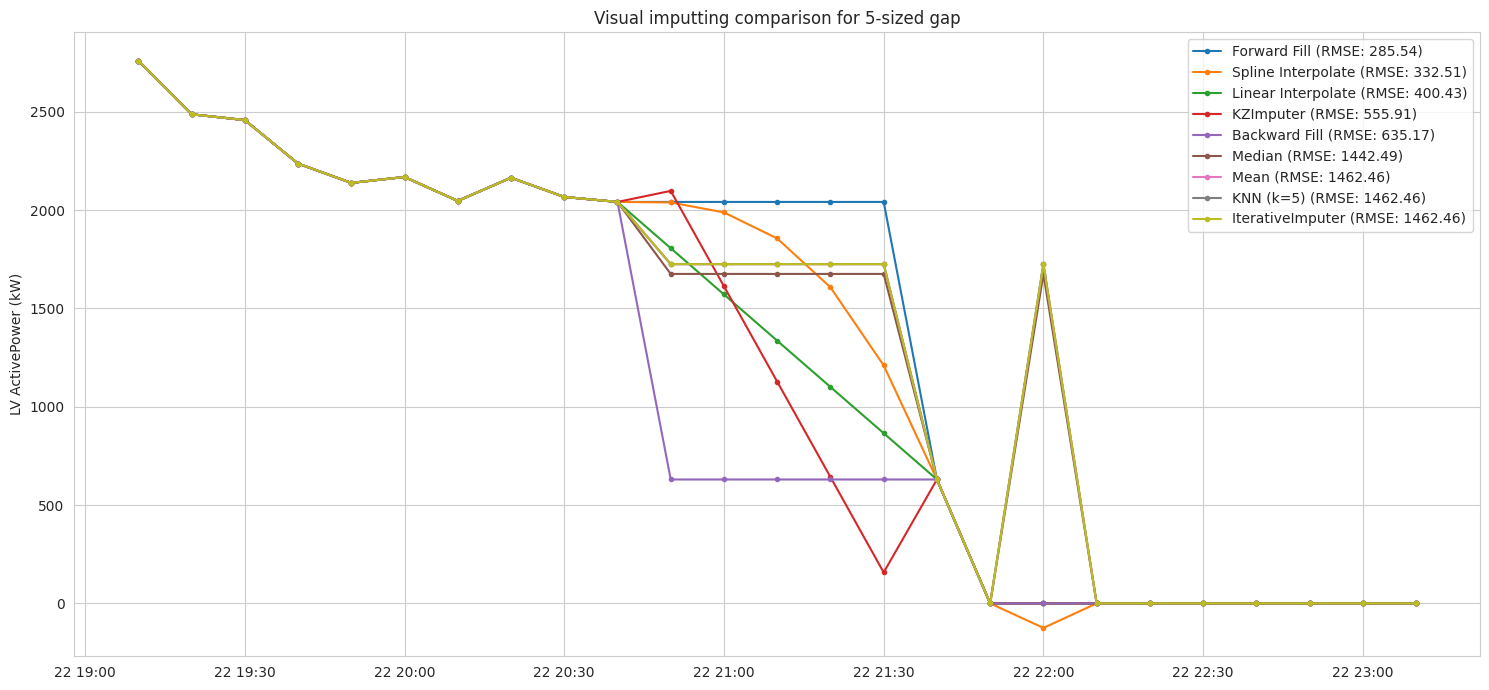

In [78]:
best_methods = results_df.sort_values('RMSE').index
max_gap = 5
for name in best_methods:
    if isinstance(imputers[name], str):
        if name == "Linear Interpolate":
            imputed = test_series.interpolate(method='linear')
        elif name == "Spline Interpolate":
            imputed = test_series.interpolate(method='spline', order=3)
        else:
            if imputers[name] == 'ffill':
                imputed = test_series.ffill()
            elif imputers[name] == 'bfill':
                imputed = test_series.bfill()
            else:
                raise ValueError(f"Unknown imputting method: {imputers[name]}")
    elif name == "KZImputer":
        kz = KZImputer(max_gap_size = max_gap)
        imputed = kz.transform(test_series)
    else:
        imputed_data = imputers[name].fit_transform(test_series_2d)
        imputed = pd.Series(imputed_data.flatten(), index=test_series.index)

    plt.plot(imputed.iloc[plot_slice], '.-', label=f'{name} (RMSE: {results_df.loc[name, "RMSE"]:.2f})')

plt.title(f'Visual imputting comparison for {max_gap}-sized gap')
plt.legend()
plt.ylabel(research_name_col)
plt.grid(True)
plt.tight_layout()
plt.show()

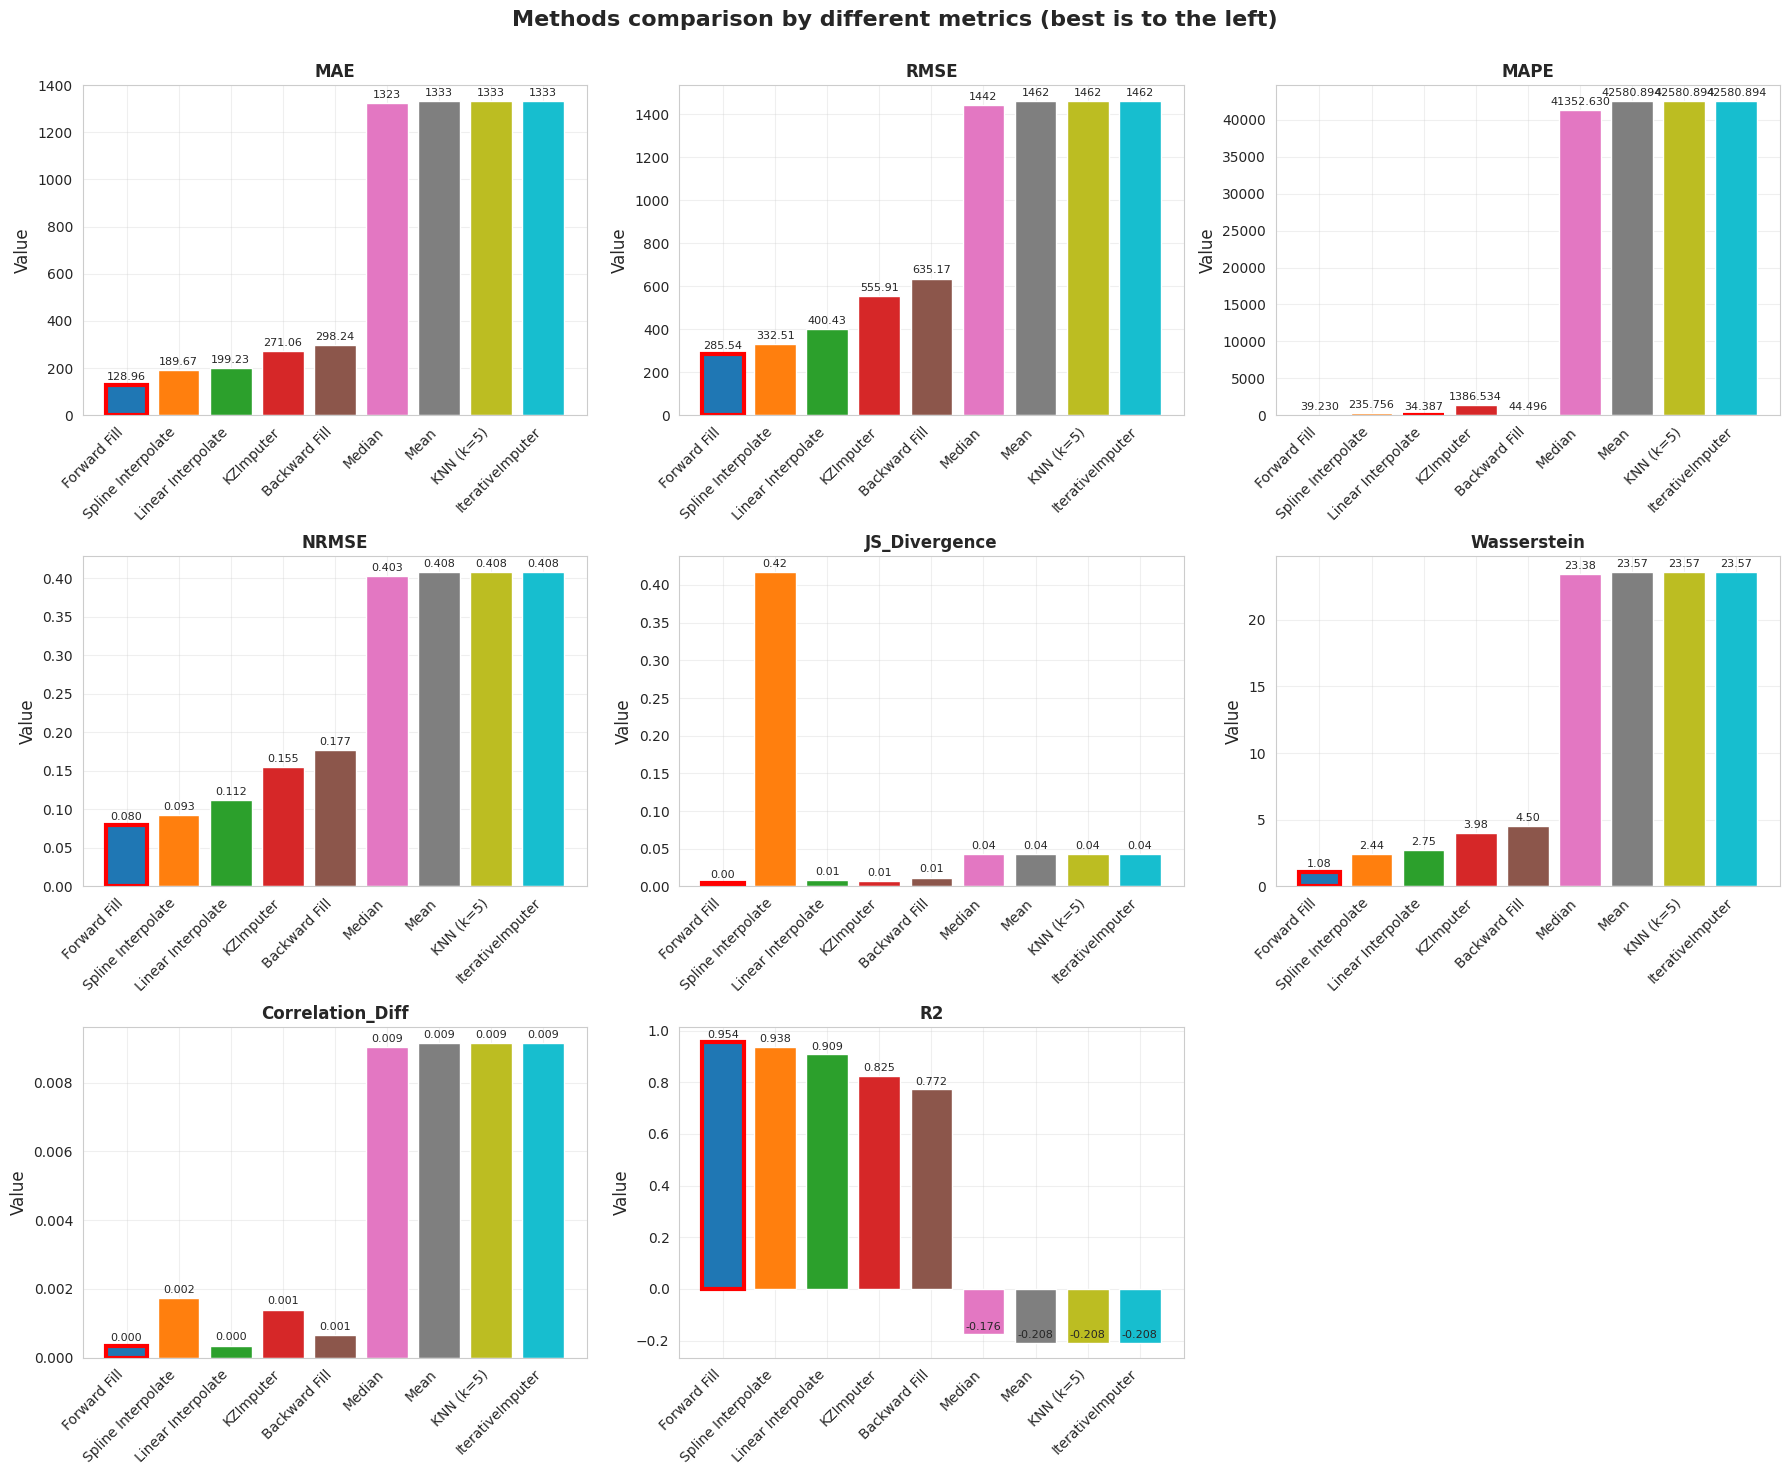

In [79]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, len(best_methods)))

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    metric_values = results_df[metric].loc[best_methods]

    bars = ax.bar(range(len(best_methods)), metric_values, color=colors)

    ax.set_xticks(range(len(best_methods)))
    ax.set_xticklabels(best_methods, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    for i, (bar, value) in enumerate(zip(bars, metric_values)):
        if not np.isnan(value):
            if metric in ['MAPE', 'R2', 'NRMSE', 'Correlation_Diff']:
                text = f'{value:.3f}'
            elif metric == ['JS_Divergence']:
                text = f'{value:.5f}'
            elif metric in ['MAE', 'RMSE', 'Wasserstein']:
                if value > 1000:
                    text = f'{value:.0f}'
                else:
                    text = f'{value:.2f}'
            else:
                text = f'{value:.2e}' if abs(value) > 1e6 else f'{value:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(metric_values),
                   text, ha='center', va='bottom', fontsize=8, rotation=0)

    if metric in minimize_metrics[:-1]:
        best_idx = np.nanargmin(metric_values)
    else:
        best_idx = np.nanargmax(metric_values)

    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)
axes[8].set_visible(False)

plt.suptitle('Methods comparison by different metrics (best is to the left)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

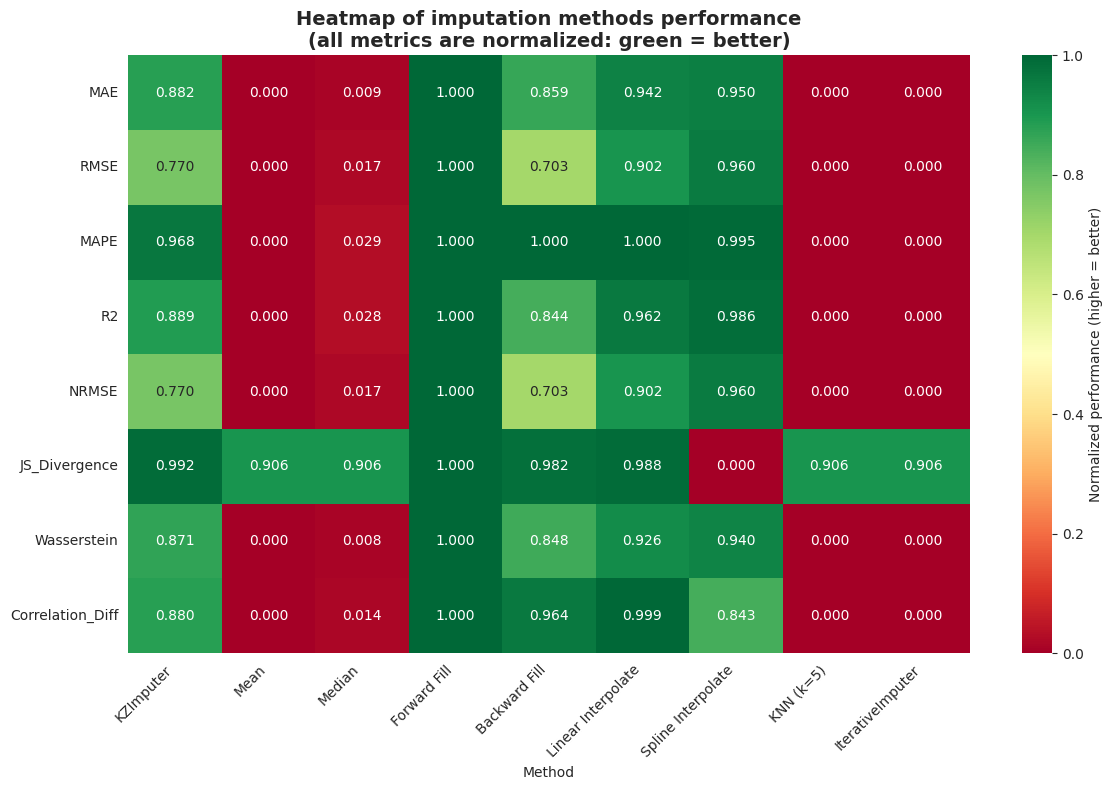

In [69]:
# Extra: Create a heat map for better visibility
plt.figure(figsize=(12, 8))

# Normalize data for heat map (0-1 scale for each metric)
normalized_data = results_df[metrics].copy()
for metric in metrics:
    if metric in minimize_metrics[:-1]:
        normalized_data[metric] = 1 - (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())
    else:
        normalized_data[metric] = (normalized_data[metric] - normalized_data[metric].min()) / (normalized_data[metric].max() - normalized_data[metric].min())

# Создаем тепловую карту
sns.heatmap(normalized_data.T,
           annot=True,
           fmt='.3f',
           cmap='RdYlGn',
           xticklabels=results_df.index,
           yticklabels=metrics,
           cbar_kws={'label': 'Normalized performance (higher = better)'})

plt.title('Heatmap of imputation methods performance\n(all metrics are normalized: green = better)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [72]:
print("\t\t\t\t\t=== FINAL TABLE OF RANKS ===")
ranks_df = pd.DataFrame(index=results_df.index, columns=metrics)

for metric in metrics:
    if metric in ['MAE', 'RMSE', 'MAPE', 'NRMSE', 'JS_Divergence', 'Wasserstein', 'Correlation_Diff']:
        ranks_df[metric] = results_df[metric].rank(ascending=True)
    else:
        ranks_df[metric] = results_df[metric].rank(ascending=False)

# add Average_rank
col_avg = 'Average_rank'
ranks_df[col_avg] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values(col_avg)

print(f"\nBest method by average rank: {ranks_df.index[0]}")
ranks_df.round(2).sort_values(by=col_avg)

					=== FINAL TABLE OF RANKS ===

Best method by average rank: Forward Fill


,MAE,RMSE,MAPE,R2,NRMSE,JS_Divergence,Wasserstein,Correlation_Diff,Average_rank
Method,,,,,,,,,
Forward Fill,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.12
Linear Interpolate,3.0,3.0,1.0,3.0,3.0,3.0,3.0,2.0,2.62
Spline Interpolate,2.0,2.0,4.0,2.0,2.0,9.0,2.0,5.0,3.50
KZImputer,4.0,4.0,5.0,4.0,4.0,2.0,4.0,4.0,3.88
Backward Fill,5.0,5.0,3.0,5.0,5.0,4.0,5.0,3.0,4.38
Median,6.0,6.0,6.0,6.0,6.0,6.5,6.0,6.0,6.06
Mean,8.0,8.0,8.0,8.0,8.0,6.5,8.0,8.0,7.81
KNN (k=5),8.0,8.0,8.0,8.0,8.0,6.5,8.0,8.0,7.81
IterativeImputer,8.0,8.0,8.0,8.0,8.0,6.5,8.0,8.0,7.81


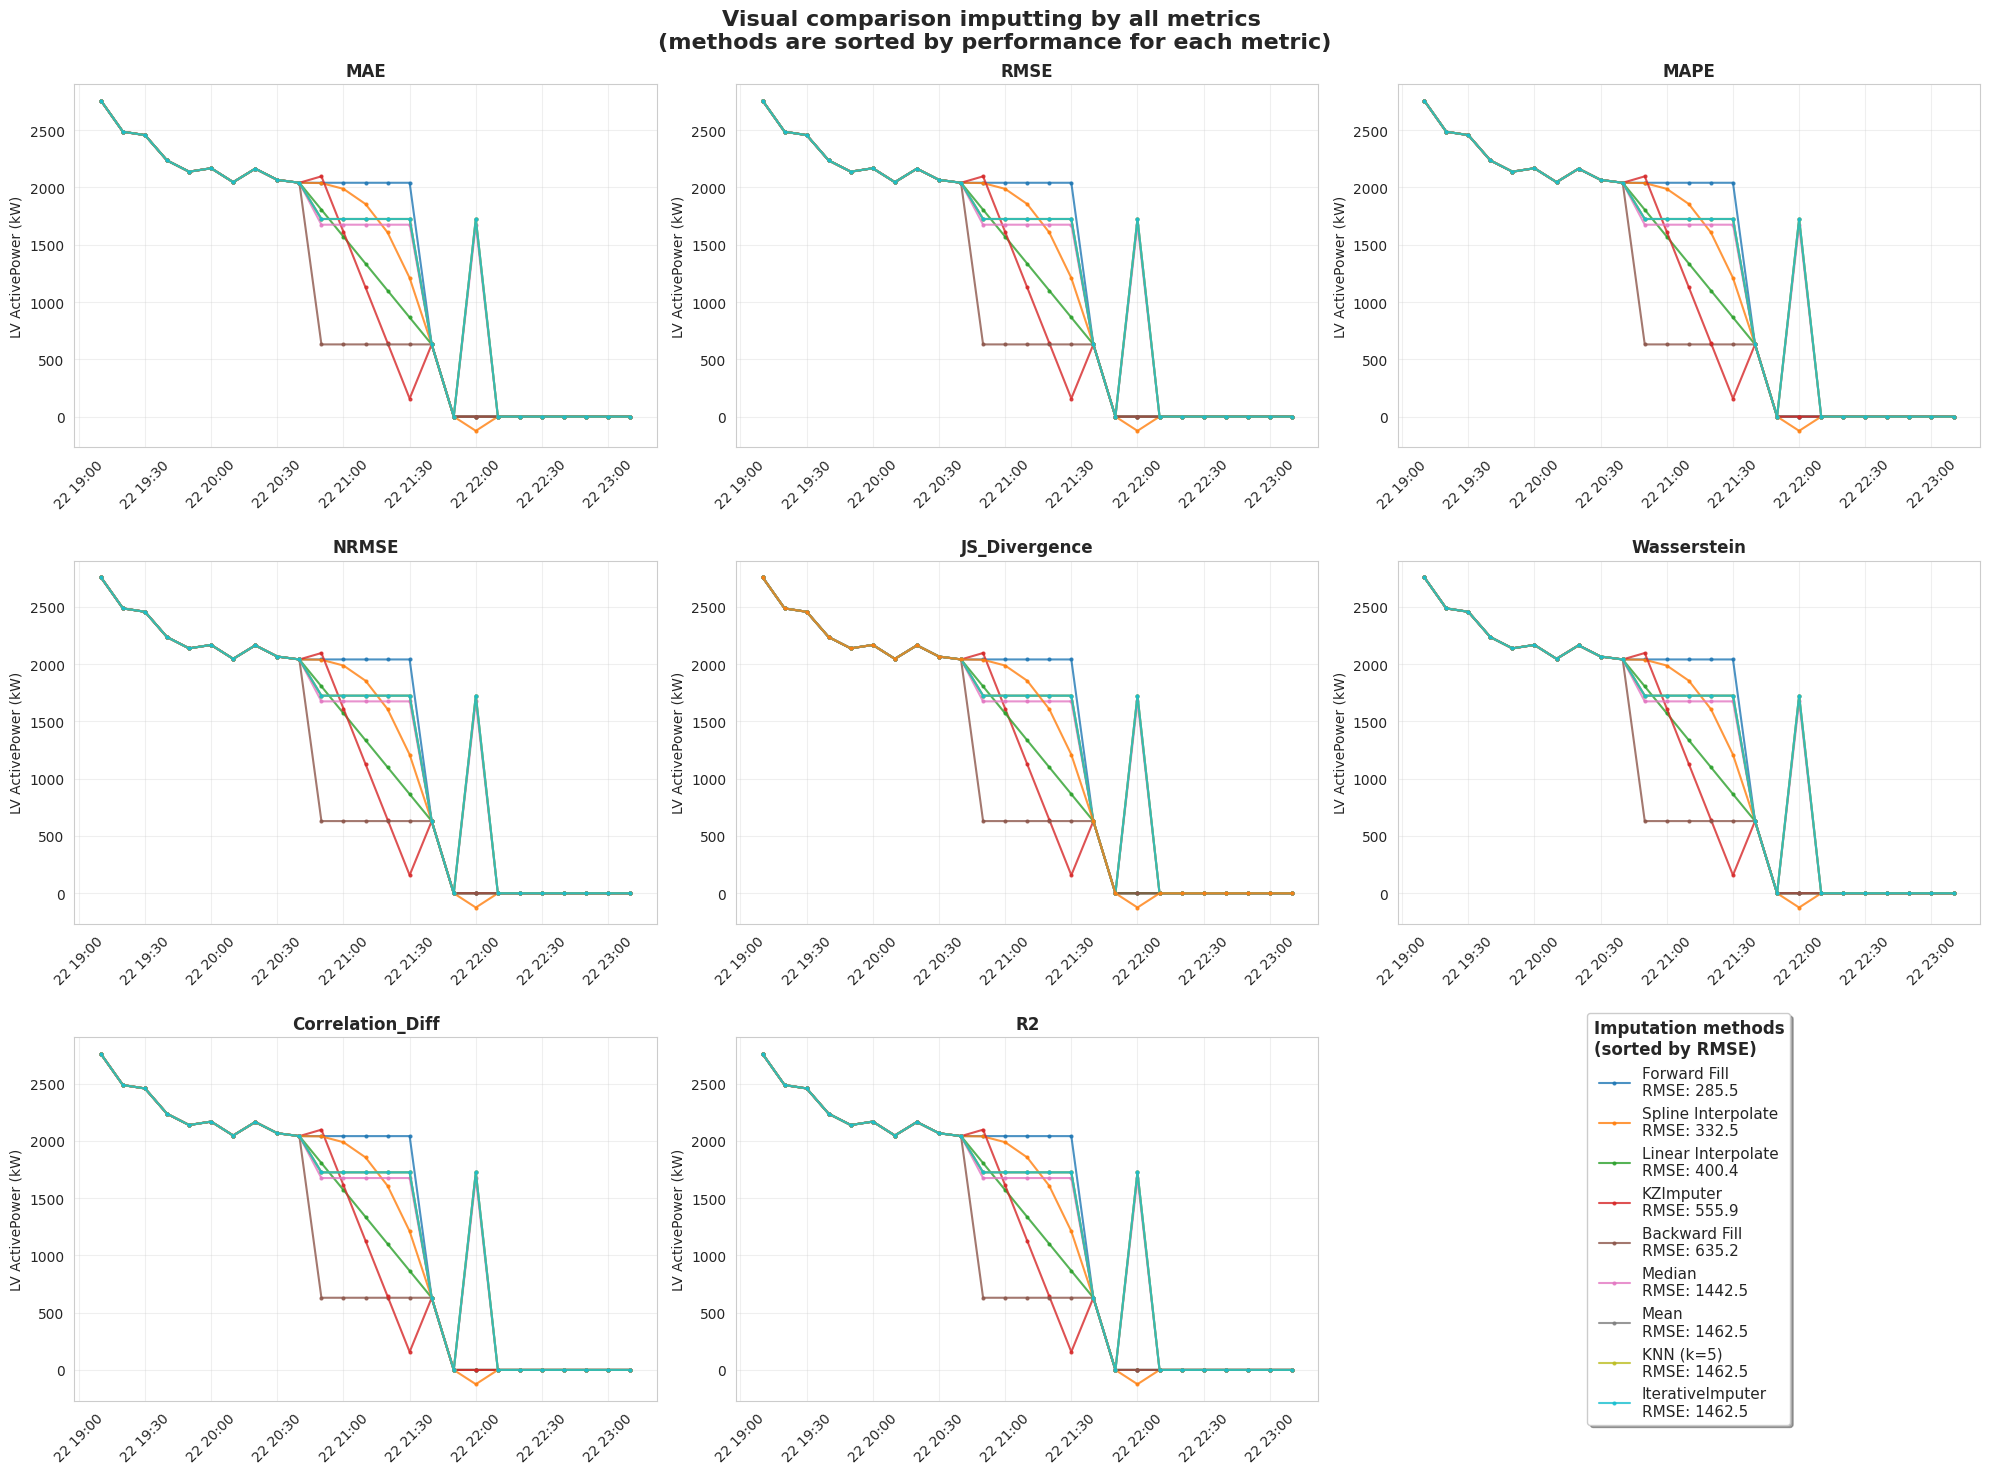

In [80]:
# create grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# colors for methods
colors = plt.cm.tab10(np.linspace(0, 1, len(best_methods)))
color_dict = {method: colors[i] for i, method in enumerate(best_methods)}

legend_handles = []
legend_labels = []

for idx, metric in enumerate(all_main_metrics):
    ax = axes[idx]

    if metric in minimize_metrics[:-1]:
        sorted_methods = results_df.sort_values(metric).index
    else:
        # for R2
        sorted_methods = results_df.sort_values(metric, ascending=False).index

    for i, name in enumerate(sorted_methods):
        if isinstance(imputers[name], str):
            if name == "Linear Interpolate":
                imputed = test_series.interpolate(method='linear')
            elif name == "Spline Interpolate":
                imputed = test_series.interpolate(method='spline', order=3)
            else:
                if imputers[name] == 'ffill':
                    imputed = test_series.ffill()
                elif imputers[name] == 'bfill':
                    imputed = test_series.bfill()
                else:
                    raise ValueError(f"Unknown imputting method: {imputers[name]}")
        elif name == "KZImputer":
            kz = KZImputer(max_gap_size=5)
            imputed = kz.transform(test_series)
        else:

            imputed_data = imputers[name].fit_transform(test_series_2d)
            imputed = pd.Series(imputed_data.flatten(), index=test_series.index)


        line = ax.plot(imputed.iloc[plot_slice], '.-',
                      color=color_dict[name],
                      alpha=0.8, linewidth=1.5, markersize=4)


        if idx == 0:
            legend_handles.append(line[0])
            legend_labels.append(f'{name}')

    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(research_name_col, fontsize=10)
    ax.grid(True, alpha=0.3)

    ax.tick_params(axis='x', rotation=45)

# set 9-th subplot as legend
legend_ax = axes[8]
legend_ax.set_xlim(0, 1)
legend_ax.set_ylim(0, 1)
legend_ax.axis('off')

# create separated legend
legend_text = []
for method in best_methods:
    metrics_str = f"RMSE: {results_df.loc[method, 'RMSE']:.1f}"
    legend_text.append(f"{method}\n{metrics_str}")

# Размещаем легенду
legend = legend_ax.legend(legend_handles, legend_text,
                         loc='center',
                         fontsize=11,
                         title='Imputation methods\n(sorted by RMSE)',
                         title_fontsize=12,
                         frameon=True,
                         fancybox=True,
                         shadow=True,
                         ncol=1)

legend.get_title().set_fontweight('bold')

plt.suptitle('Visual comparison imputting by all metrics \n(methods are sorted by performance for each metric)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()